In [ ]:
!pip install tslearn

In [ ]:
! pip install yfinance

In [ ]:
! pip install yahoo_fin

In [4]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yfinance as yf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [5]:
import yahoo_fin.stock_info as si
sp500 = si.tickers_sp500()

In [6]:
len(sp500)

505

In [7]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [8]:
snp500_all = []

tiker_list = sp500.copy()

for ticker in tqdm(tiker_list):
    try:
        ticker_obj = yf.Ticker(ticker)
        close_price = ticker_obj.history(period='6mo')['Close'].to_dict()
        info = get_info(ticker_obj)
        info.update(close_price)
        snp500_all.append(info)
    except:
        continue
        
snp500_all = pd.DataFrame(snp500_all)

  0%|          | 0/505 [00:00<?, ?it/s]

In [9]:
snp500_all.dropna(axis=1, how='all', inplace=True)
snp500_all.dropna(axis=1, inplace=True)

In [10]:
snp500_all.head(5)

,shortName,sector,industry,country,market,2021-07-01 00:00:00,2021-07-02 00:00:00,2021-07-06 00:00:00,2021-07-07 00:00:00,2021-07-08 00:00:00,2021-07-09 00:00:00,2021-07-12 00:00:00,2021-07-13 00:00:00,2021-07-14 00:00:00,2021-07-15 00:00:00,2021-07-16 00:00:00,2021-07-19 00:00:00,2021-07-20 00:00:00,2021-07-21 00:00:00,2021-07-22 00:00:00,2021-07-23 00:00:00,2021-07-26 00:00:00,2021-07-27 00:00:00,2021-07-28 00:00:00,2021-07-29 00:00:00,2021-07-30 00:00:00,2021-08-02 00:00:00,2021-08-03 00:00:00,2021-08-04 00:00:00,2021-08-05 00:00:00,2021-08-06 00:00:00,2021-08-09 00:00:00,2021-08-10 00:00:00,2021-08-11 00:00:00,2021-08-12 00:00:00,2021-08-13 00:00:00,2021-08-16 00:00:00,2021-08-17 00:00:00,2021-08-18 00:00:00,2021-08-19 00:00:00,...,2021-11-03 00:00:00,2021-11-04 00:00:00,2021-11-05 00:00:00,2021-11-08 00:00:00,2021-11-09 00:00:00,2021-11-10 00:00:00,2021-11-11 00:00:00,2021-11-12 00:00:00,2021-11-15 00:00:00,2021-11-16 00:00:00,2021-11-17 00:00:00,2021-11-18 00:00:00,2021-11-19 00:00:00,2021-11-22 00:00:00,2021-11-23 00:00:00,2021-11-24 00:00:00,2021-11-26 00:00:00,2021-11-29 00:00:00,2021-11-30 00:00:00,2021-12-01 00:00:00,2021-12-02 00:00:00,2021-12-03 00:00:00,2021-12-06 00:00:00,2021-12-07 00:00:00,2021-12-08 00:00:00,2021-12-09 00:00:00,2021-12-10 00:00:00,2021-12-13 00:00:00,2021-12-14 00:00:00,2021-12-15 00:00:00,2021-12-16 00:00:00,2021-12-17 00:00:00,2021-12-20 00:00:00,2021-12-21 00:00:00,2021-12-22 00:00:00,2021-12-23 00:00:00,2021-12-27 00:00:00,2021-12-28 00:00:00,2021-12-29 00:00:00,2021-12-30 00:00:00
0,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,United States,us_market,147.412430,148.634933,148.794724,149.304092,148.644913,149.843414,149.324051,149.084366,148.445160,148.774750,148.744781,147.396469,149.114319,148.764755,150.113083,152.120575,150.063141,149.763504,151.271637,152.480133,153.039429,152.879639,153.668655,154.078140,154.847183,155.506363,156.345306,156.325348,156.325348,157.953308,159.031967,161.868454,160.709885,162.817261,167.461472,...,158.199997,157.649994,156.410004,160.940002,159.809998,159.279999,158.789993,160.880005,157.779999,161.389999,161.539993,162.160004,164.300003,162.779999,154.779999,152.970001,152.070007,153.419998,150.899994,148.210007,150.990005,149.330002,151.470001,153.800003,156.309998,154.610001,156.259995,156.289993,151.880005,154.309998,150.800003,151.419998,150.419998,153.960007,156.779999,157.800003,158.740005,159.179993,160.649994,160.880005
1,"American Airlines Group, Inc.",Industrials,Airlines,United States,us_market,21.510000,21.480000,21.010000,20.309999,20.350000,20.889999,20.840000,20.020000,20.620001,20.459999,19.790001,18.969999,20.559999,21.400000,21.160000,21.200001,22.080000,21.459999,21.629999,21.170000,20.379999,20.059999,19.950001,19.450001,20.910000,21.020000,20.559999,20.940001,21.230000,20.430000,19.840000,19.760000,19.340000,19.139999,18.730000,...,20.629999,20.629999,21.820000,22.250000,22.260000,21.570000,21.330000,20.290001,20.320000,19.840000,19.860001,19.389999,19.280001,19.629999,19.469999,19.459999,17.750000,17.740000,17.690001,16.280001,17.420000,16.620001,17.930000,17.889999,18.230000,18.139999,18.010000,17.120001,16.910000,16.990000,16.520000,16.950001,17.299999,18.120001,18.260000,18.260000,18.170000,18.540001,18.049999,18.070000
2,Advance Auto Parts Inc.,Consumer Cyclical,Specialty Retail,United States,us_market,207.057281,209.148285,206.819458,207.552780,205.640167,211.546478,210.020340,207.087021,208.266312,207.364502,203.995132,203.816757,208.335663,207.513138,208.395111,213.013123,212.160889,213.429352,210.337463,211.467194,210.149170,210.793320,213.459076,207.780701,204.480713,203.866302,202.677124,206.859100,209.306839,207.414047,204.569901,210.347366,205.897827,205.749176,206.492416,...,229.994217,229.127853,228.769348,226.956970,231.418228,233.788284,237.452896,238.040421,240.898422,234.704437,231.577560,230.950195,229.038223,230.860580,234.784103,232.394135,225.781891,226.319641,219.797028,217.317444,227.80340

In [12]:
summary = snp500_all[['sector', 'industry', 'country', 'market', 'shortName']].copy()
summary['start'] = snp500_all.iloc[:, 5]
summary['stop'] = snp500_all.iloc[:, -1]
summary['difference-'] = snp500_all.iloc[:, -1] - snp500_all.iloc[:, 5]
summary['difference/'] = snp500_all.iloc[:, -1] / snp500_all.iloc[:, 5]
summary['mean'] = snp500_all.iloc[:, 5:131].T.mean()
summary['std'] = snp500_all.iloc[:, 5:131].T.std()

In [13]:
summary.sort_values(['difference/', 'sector', 'industry', 'country'], ascending=False).head(50)

,sector,industry,country,market,shortName,start,stop,difference-,difference/,mean,std
447,Consumer Cyclical,Auto Manufacturers,United States,us_market,"Tesla, Inc.",677.919983,1070.339966,392.419983,1.578859,852.840314,177.417960
35,Technology,Computer Hardware,United States,us_market,"Arista Networks, Inc.",90.847504,143.149994,52.302490,1.575717,104.902024,18.545195
29,Technology,Semiconductors,United States,us_market,"Advanced Micro Devices, Inc.",93.309998,145.149994,51.839996,1.555567,117.904286,21.057845
496,Technology,Semiconductors,United States,us_market,"Xilinx, Inc.",141.809998,213.889999,72.080002,1.508286,171.223730,31.325614
363,Healthcare,Drug Manufacturers—General,United States,us_market,"Pfizer, Inc.",38.863777,58.400002,19.536224,1.502685,46.415043,5.643725
149,Energy,Oil & Gas E&P,United States,us_market,Devon Energy Corporation,29.079344,43.669998,14.590654,1.501753,34.200550,7.079261
196,Technology,Software—Infrastructure,United States,us_market,"Fortinet, Inc.",242.339996,359.779999,117.440002,1.484608,308.474364,27.575882
340,Technology,Semiconductors,United States,us_market,NVIDIA Corporation,202.119995,295.859985,93.739990,1.463784,240.544941,45.581439
183,Financial Services,Financial Data & Stock Exchanges,United States,us_market,FactSet Research Systems Inc.,334.499420,484.739990,150.240570,1.449150,403.893872,47.939186
48,Technology,Semiconductors,United States,us_market,Broadcom Inc.,463.259796,665.080017,201.820221,1.435652,517.282233,54.271071


In [14]:
# plot random 50
snp500 = snp500_all.sample(50)
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(snp500.iloc[:, 5:].T).T

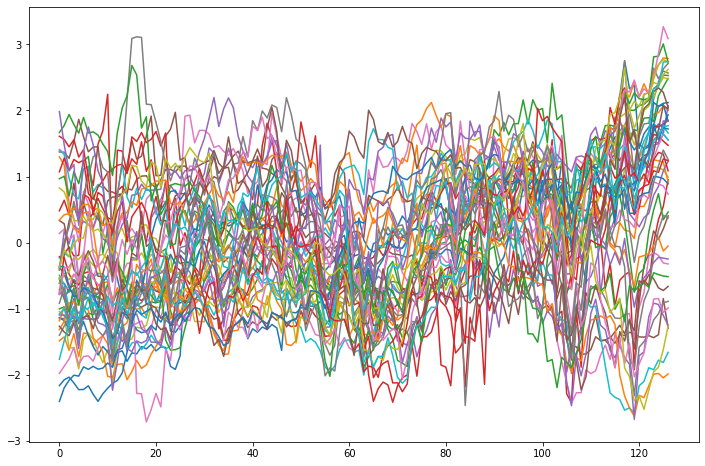

In [15]:
plt.figure(figsize=(12,8))
plt.plot(tickers_scaled.T)

# Basik KMeans

  0%|          | 0/9 [00:00<?, ?it/s]

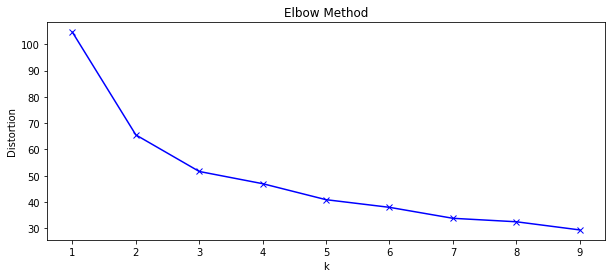

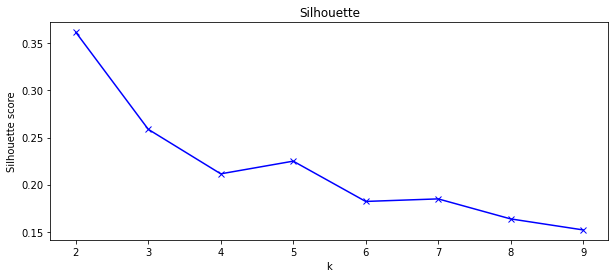

In [16]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [17]:
n_clusters = 7
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=7, n_jobs=3)

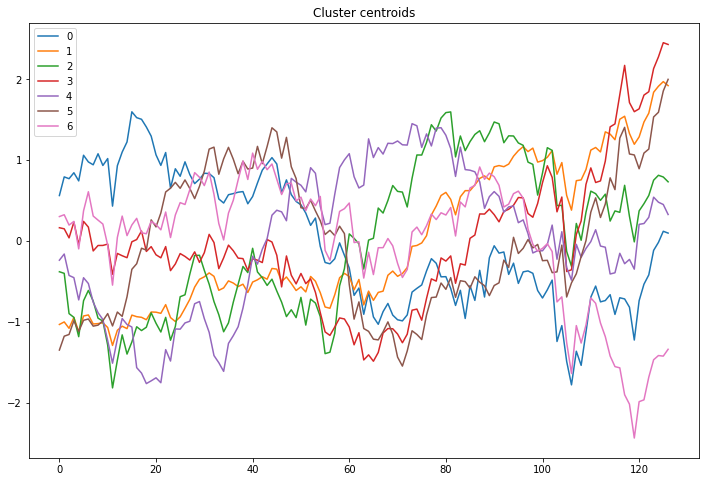

In [18]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [19]:
snp500['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


sector
cluster sector                    
0       Healthcare               3
        Technology               2
        Consumer Cyclical        1
        Real Estate              1
1       Healthcare               3
        Industrials              3
        Basic Materials          2
        Consumer Cyclical        2
        Consumer Defensive       2
        Energy                   1
        Real Estate              1
        Technology               1
2       Financial Services       3
        Energy                   2
        Basic Materials          1
3       Consumer Defensive       3
        Financial Services       2
        Utilities                2
        Industrials              1
4       Consumer Cyclical        1
        Financial Services       1
        Technology               1
5       Healthcare               4
        Utilities                1
6       Financial Services       3
        Consumer Defensive       1
        Healthcare               1
        Industrials              1

In [20]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


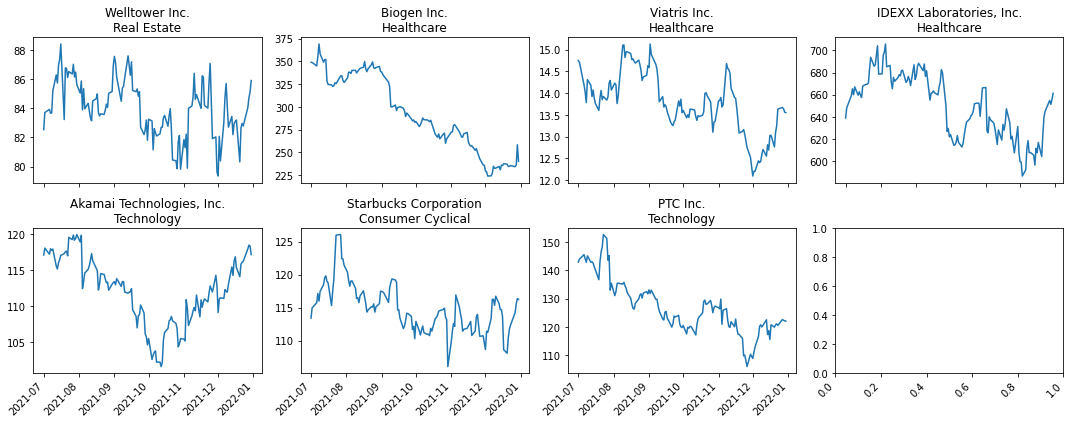

                          Cluster number: 1


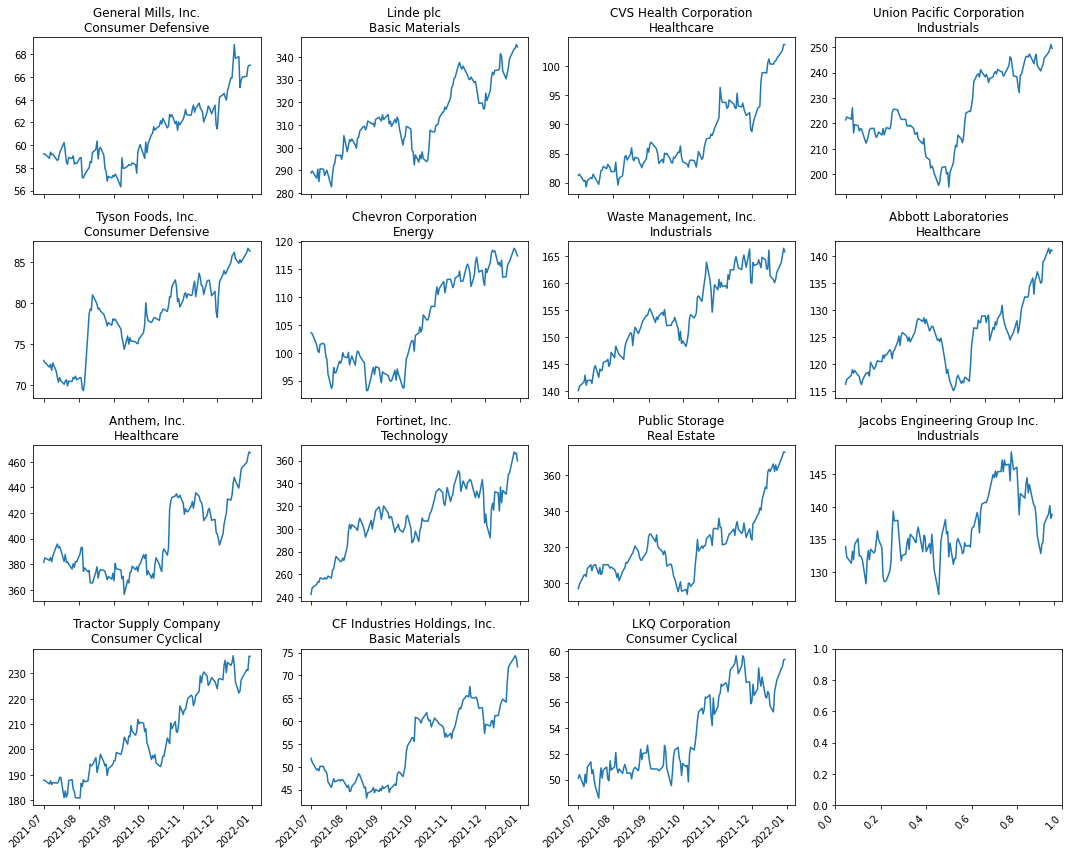

                          Cluster number: 2


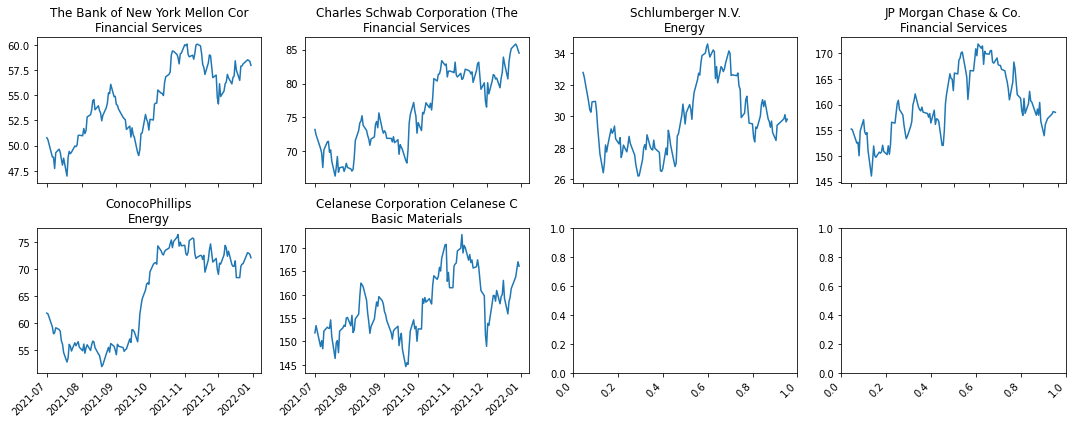

                          Cluster number: 3


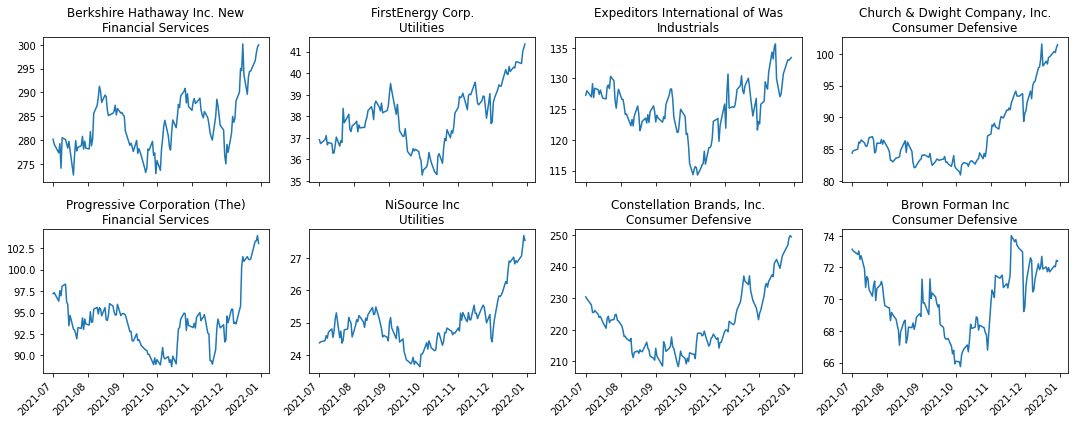

                          Cluster number: 4


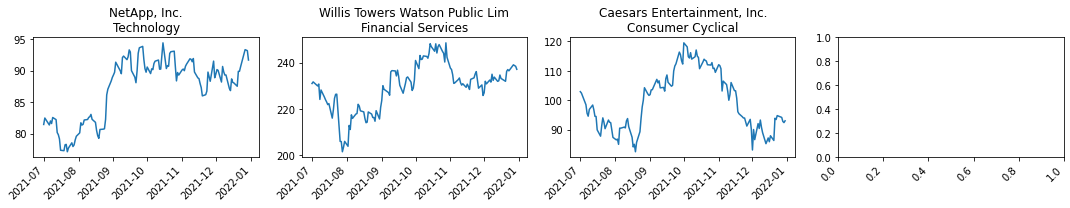

                          Cluster number: 5


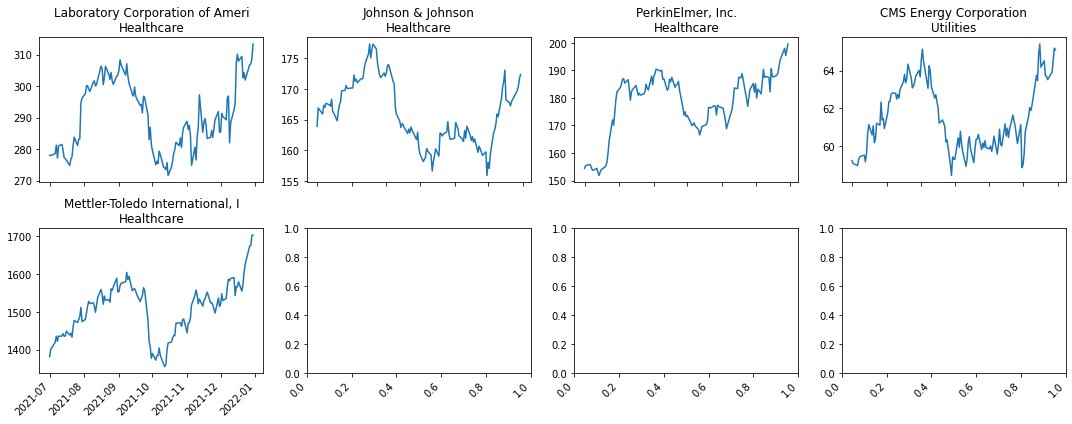

                          Cluster number: 6


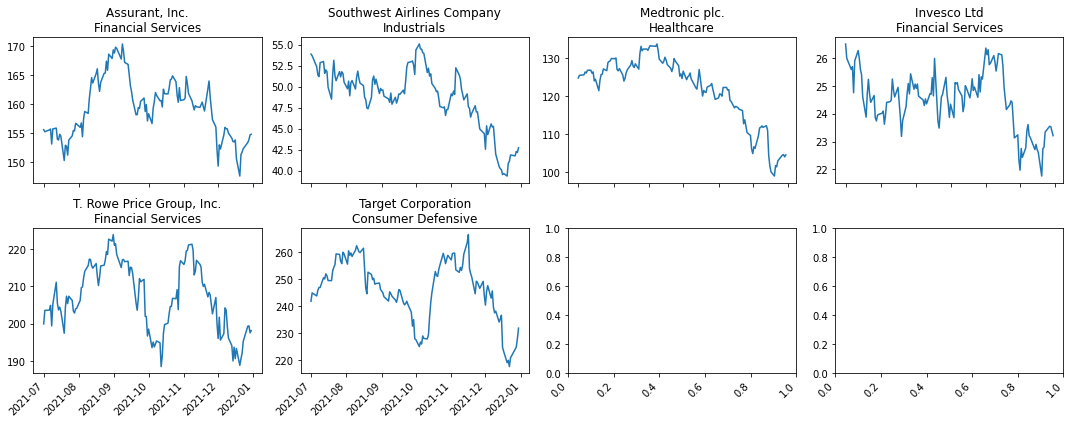

In [21]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])

### DTW

In [ ]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [ ]:
n_clusters = 7
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

In [ ]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")

plt.legend()
plt.show()

In [ ]:
snp500['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])